In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [2]:
import numpy as np
import xesmf as xe
import xarray as xr

import copy

from scipy import stats, signal
# from functions import func_conv_data

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
col = open_catalog(url).climate.cmip6_gcs()

In [5]:
def rename_coords(ds):
    ds = ds.copy()
    """Rename all depth dim to `lev`"""
    if "olevel" in ds.coords:
        ds = ds.rename({"olevel": "lev"})
    if "lev_partial" in ds.coords:
        ds = ds.rename({"lev_partial": "lev"})
    """Rename all latitude, longitude dim to `lat`,`lon`"""
    if 'latitude' in ds.coords:
        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in ds.coords:
        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    return ds

def get_dataset(col, var, freq, expe, model, grid):
    dataset = col.search(variable_id = var, table_id = freq, experiment_id = expe, 
                         source_id = model, grid_label = grid).to_dataset_dict(
        zarr_kwargs= {'consolidated': True, 'decode_times':True}, preprocess = rename_coords)
    dataset = dataset[list(dataset)[0]].squeeze('member_id').reset_coords('member_id', drop = True)
    return dataset

In [6]:
model_name = 'GFDL-CM4' 
experiment = 'piControl'
frequency = 'Omon'
variables = ['so', 'thetao', 'uo', 'vo']

In [7]:
dataset_gn = get_dataset(col, variables, frequency, experiment, model_name, 'gn')
dataset_gr = get_dataset(col, variables, frequency, experiment, model_name, 'gr')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
ds_sst_NA = dataset_gr.thetao.isel(lev=0).sel(lat=slice(0,60),lon=slice(285,353)) ## [0-60N, 7.5W-75W]
ds_sst_NA_ann = ds_sst_NA.groupby('time.year').mean(dim = 'time', skipna = True)
AMV = ds_sst_NA_ann.mean(dim = 'lon', skipna = True).mean(dim = 'lat', skipna = True)

In [9]:
def func_regrid(ds, ds_out, gr_method = 'bilinear', reuse = False, clear = True):
    dsr = xe.Regridder(ds, ds_out, gr_method, periodic = True, 
                       reuse_weights = reuse, ignore_degenerate = True)
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
    if clear:
        dsr.clean_weight_file()
    return dsr_out

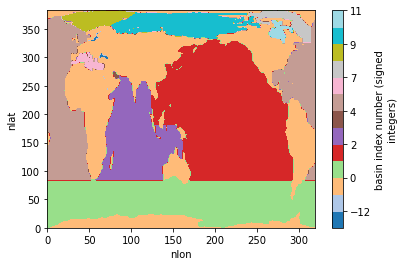

In [10]:
## File modified from https://pop-tools.readthedocs.io/en/latest/examples/region-mask.html
ocean_mask = xr.open_dataset("OceanMask.nc")
# ocean_mask['TLONG'] = ((ocean_mask.TLONG + 300) % 360) - 300

ocean_mask.REGION_MASK.plot.contourf(levels = np.array(np.unique(ocean_mask.REGION_MASK)), cmap = 'tab20')
###########################
## 1  Southern Ocean
## 2  Pacific Ocean
## 6  Atlantic Ocean + 9 + 11
## 10 Arctic Ocean

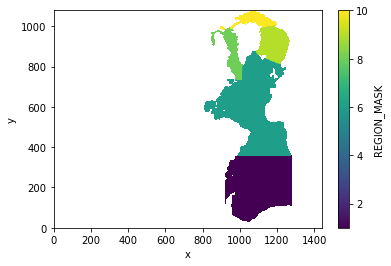

In [11]:
# Atlantic Ocean Mask
mask_a = ocean_mask.where(ocean_mask.REGION_MASK.isin([6, 8]))
mask_b = ocean_mask.where(ocean_mask.REGION_MASK.isin([1]))
mask_b = xr.merge([mask_b.REGION_MASK.where(mask_b.TLONG < 20), 
                   mask_b.REGION_MASK.where(mask_b.TLONG >= 290)], compat="no_conflicts")
mask_c = ocean_mask.where(ocean_mask.REGION_MASK.isin([9, 10]))
mask_c = xr.merge([mask_c.REGION_MASK.where(mask_c.TLONG < 20), 
                   mask_c.REGION_MASK.where(mask_c.TLONG >= 270)], compat="no_conflicts")
mask = xr.merge([mask_a, mask_b, mask_c], compat="no_conflicts")
mask = mask.rename({'TLONG': 'lon', 'TLAT': 'lat'})
ds_out = xr.Dataset({'lat': dataset_gn.lat, 'lon':dataset_gn.lon})
mask = func_regrid(mask.REGION_MASK, ds_out, reuse = False, clear = False)
mask.plot()

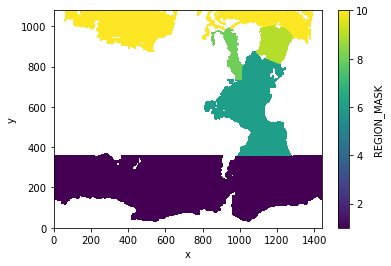

In [18]:
# need to adjust & think about the calculations(streamfunction)
# not use now
mask_new = ocean_mask.where(ocean_mask.REGION_MASK.isin([1, 6, 8, 9, 10]))
mask_new = mask_new.rename({'TLONG': 'lon', 'TLAT': 'lat'})
ds_out = xr.Dataset({'lat': dataset_gn.lat, 'lon':dataset_gn.lon})
mask = func_regrid(mask_new.REGION_MASK, ds_out, reuse = False, clear = False)
mask.plot()

In [12]:
ds_v = dataset_gn.vo.where(~np.isnan(mask), drop = True)

In [13]:
def calc_dx_dy_bnd(ds):
    from pyproj import Geod
    
    g = Geod(ellps='sphere')
    
    lonb = ds.lon_bnds.values
    latb = ds.lat_bnds.values
    
    dx = np.zeros((lonb.shape[0], lonb.shape[1]))
    dy = np.zeros((lonb.shape[0], lonb.shape[1]))
    
    for i in range(dx.shape[0]):
        for j in range(dx.shape[1]):
            _, _, dy[i,j] = g.inv(lonb[i,j,1], latb[i,j,1], lonb[i,j,2], latb[i,j,2])
            
    for i in range(dx.shape[0]):
        for j in range(dy.shape[1]):
            _, _, dx[i,j] = g.inv(lonb[i,j,0], latb[i,j,0], lonb[i,j,1], latb[i,j,1])
    
    return dx, dy

In [14]:
dep = np.squeeze(np.diff(dataset_gn.lev_bnds.values))
newdep = np.tile(dep[:, np.newaxis, np.newaxis], (1, ds_v.shape[2], ds_v.shape[3]))
vol_z = newdep * ds_v
newmask = mask.where(~np.isnan(mask), drop = True)
dx, dy = calc_dx_dy_bnd(dataset_gn.where(~np.isnan(mask), drop = True))

In [15]:
def func_integral_lon(ds, dx):
    vol_U = ds * dx / 1e6
    vol_U_Int = vol_U.sum(dim = 'x', skipna = True)
    return vol_U_Int

In [16]:
vol_lon = func_integral_lon(vol_z, dx)
vol_lon = vol_lon.groupby('time.year').mean(dim = 'time', skipna = True)

stfunc_sum = vol_lon.sum(dim = 'lev', skipna = True)
stfunc_cumsum = vol_lon.cumsum(dim = 'lev')
stream_function = stfunc_cumsum - stfunc_sum 

AMOC_max = stream_function.max(dim = 'lev')

In [17]:
### Yucatan Channel Flow
vo_yct = dataset_gn.vo.isel(x = slice(852,861), y = slice(591,593))
dx, dy = calc_dx_dy_bnd(dataset_gn.isel(x=slice(852,861),y=slice(591,593)))
vol_yct = func_integral_lon(vo_yct, dx) * np.tile(dep[:, np.newaxis], (1, vo_yct.shape[2]))
flow_yct = vol_yct.groupby('time.year').mean('time')
flow_yct_ave = flow_yct.mean('y')  # not mean --> should be sum

In [18]:
# SSS
ds_sss = dataset_gr.so.isel(lev=0)
ds_sss_ann = ds_sss.groupby('time.year').mean('time')
sss_by_lat = ds_sss_ann.mean(dim='lat', skipna = True)

In [40]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

options.worker_cores = 4 #16 / 4
options.worker_memory = 32 #32 / 8  

cluster = gateway.new_cluster(options)
# cluster.scale(25) 
cluster.adapt(minimum = 0, maximum = 100)

client = cluster.get_client() 
cluster

In [41]:
AMV = AMV.load()

Text(0.5, 1.0, 'AMV index timeseries [0-60N, 7.5W-75W], GFDL-CM4')

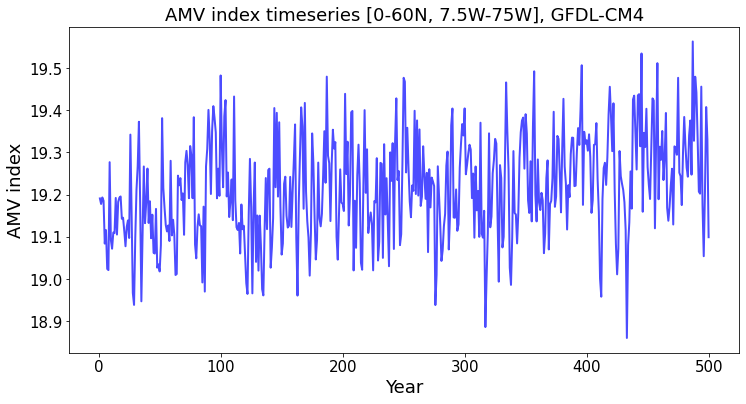

In [44]:
fig = plt.figure(figsize=(12,6))

plt.plot(AMV.year - 150, AMV, 'b', linewidth = 2, alpha=0.7)

plt.ylabel('AMV index', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('AMV index timeseries [0-60N, 7.5W-75W], GFDL-CM4', fontsize=18)

In [45]:
from scipy.signal import detrend

AMV_mean = AMV.mean(dim='year', skipna=True)
AMV_anom = AMV - AMV_mean
AMV_anom_detrended = detrend(AMV_anom.values)
AMV_detrend = AMV_anom_detrended + AMV_mean.values

Text(0.5, 1.0, 'AMV index timeseries (detrended) [0-60N, 7.5W-75W], GFDL-CM4')

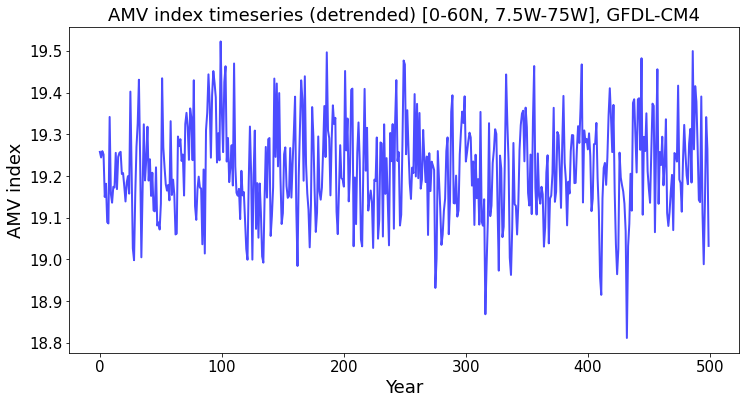

In [46]:
fig = plt.figure(figsize=(12,6))

plt.plot(AMV_detrend, 'b', linewidth = 2, alpha=0.7)

plt.ylabel('AMV index', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('AMV index timeseries (detrended) [0-60N, 7.5W-75W], GFDL-CM4', fontsize=18)

In [47]:
# Butterworth filter 
def butterwort_filter(CutOff_T, n_order, ds):
    # CutOff_T = 10 # Cut-off period 
    # n_order = 1 # Order of filtering
    fs = 1  # Sampling frequency, equal to 1 year in our case
    fc = 1/CutOff_T  # Cut-off frequency of the filter
    ww = fc / (fs / 2) # Normalize the frequency
    bb, aa = signal.butter(n_order, ww, 'low')
    ds_bwfilt = signal.filtfilt(bb, aa, ds)
    return ds_bwfilt

Text(0.5, 1.0, 'AMV index timeseries [0-60N, 7.5W-75W], GFDL-CM4 \n Butterworth filtered (10yr cut-off)')

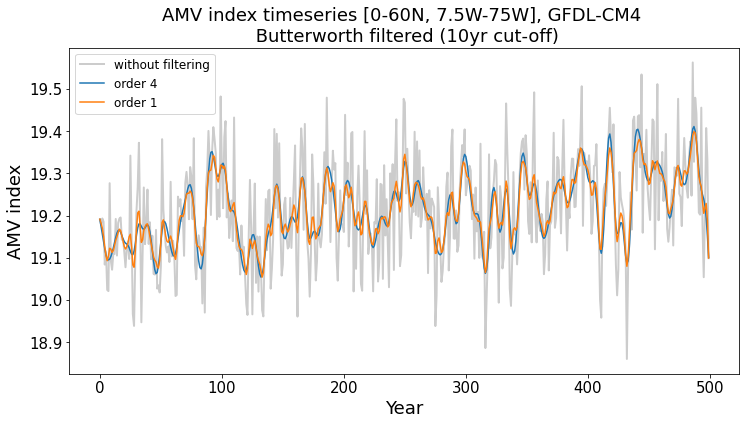

In [79]:
fig = plt.figure(figsize=(12,6))

plt.plot(AMV, 'black', linewidth = 2, alpha=0.2, label = 'without filtering')

CutOff_T = 10
for n in [4,1]:
    plt.plot(butterwort_filter(CutOff_T, n, AMV.values), linewidth = 1.5, label = 'order {}'.format(n))

plt.ylabel('AMV index', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)
plt.title('AMV index timeseries [0-60N, 7.5W-75W], GFDL-CM4 \n Butterworth filtered (10yr cut-off)', fontsize=18)

In [71]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [72]:
AMV_detrend_rm = runningMeanFast(AMV_detrend, 10)

Text(0.5, 1.0, 'AMV index timeseries [0-60N, 7.5W-75W], GFDL-CM4 \n Detrended, RunningMeanFast filtered (10yr)')

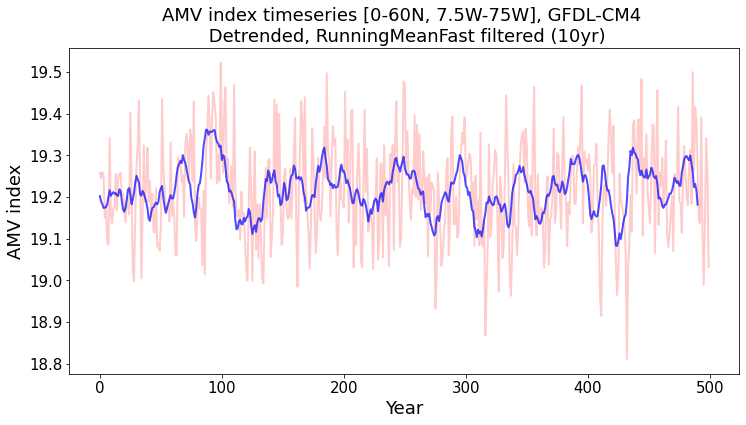

In [73]:
fig = plt.figure(figsize=(12,6))

plt.plot(AMV_detrend, 'r', linewidth = 2, alpha=0.2)
plt.plot(AMV_detrend_rm[:-9], 'b', linewidth = 2, alpha=0.7)

plt.ylabel('AMV index', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('AMV index timeseries [0-60N, 7.5W-75W], GFDL-CM4 \n Detrended, RunningMeanFast filtered (10yr)', fontsize=18)

In [42]:
AMOC_max = AMOC_max.load()

In [43]:
flow_yct_ave = flow_yct_ave.load()

Text(0.5, 1.0, 'Yucatan Channel surface flow timeseries, GFDL-CM4')

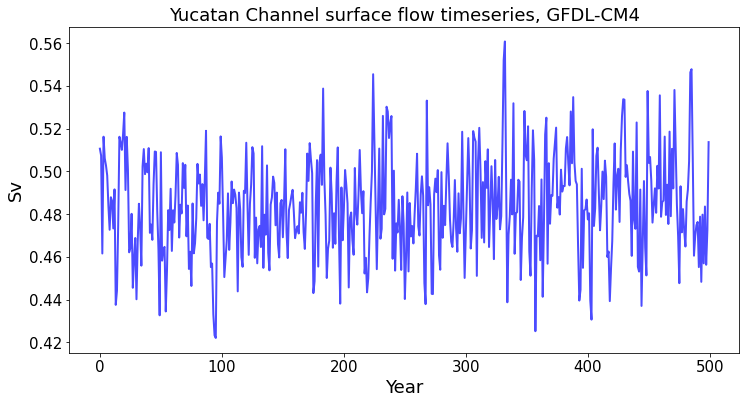

In [78]:
fig = plt.figure(figsize=(12,6))

plt.plot(flow_yct_ave.isel(lev=0), 'b', linewidth = 2, alpha=0.7)

plt.ylabel('Sv', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Yucatan Channel surface flow timeseries, GFDL-CM4', fontsize=18)

Text(0.5, 1.0, 'Yucatan Channel surface flow timeseries, GFDL-CM4')

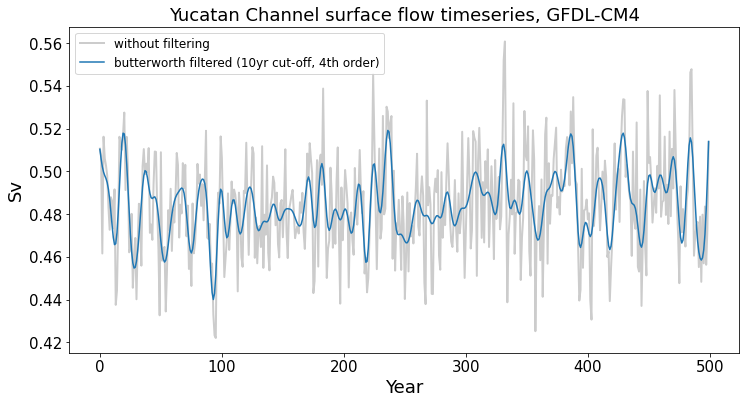

In [80]:
fig = plt.figure(figsize=(12,6))

plt.plot(flow_yct_ave.isel(lev=0), 'black', linewidth = 2, alpha=0.2, label = 'without filtering')

plt.plot(butterwort_filter(10, 4, flow_yct_ave.isel(lev=0).values), linewidth = 1.5, label = 'butterworth filtered (10yr cut-off, 4th order)')

plt.ylabel('Sv', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)
plt.title('Yucatan Channel surface flow timeseries, GFDL-CM4', fontsize=18)

In [84]:
AMOC_bwfilt = {}
for yi in range(-70, 80, 10):
    AMOC_bwfilt[str(yi)] = butterwort_filter(10, 4, AMOC_max.sel(y = yi, method = 'nearest').values)

Text(0.5, 1.0, 'AMOC at 30N timeseries, GFDL-CM4')

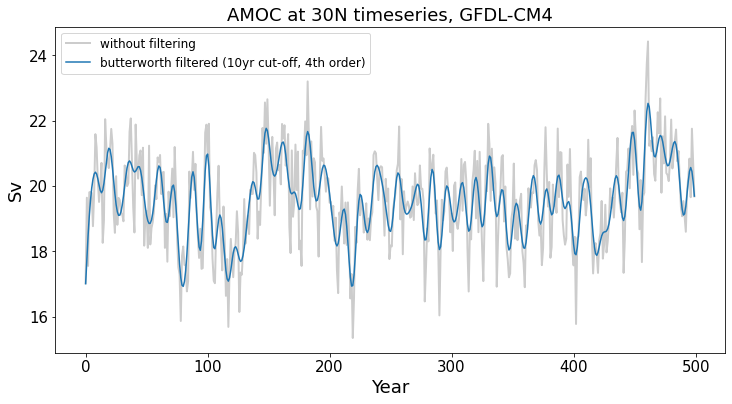

In [81]:
fig = plt.figure(figsize=(12,6))

plt.plot(AMOC_30N, 'black', linewidth = 2, alpha=0.2, label = 'without filtering')

plt.plot(butterwort_filter(10, 4, AMOC_30N.values), linewidth = 1.5, label = 'butterworth filtered (10yr cut-off, 4th order)')

plt.ylabel('Sv', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)
plt.title('AMOC at 30N timeseries, GFDL-CM4', fontsize=18)

In [86]:
def lag_cor_data(x, y, lag):
    corr = []
    for i in range(2*lag):
        corr.append(stats.pearsonr(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])[0])
    return corr

Text(0.5, 1.0, 'AMV index Convection lagged correlation , GFDL-CM4')

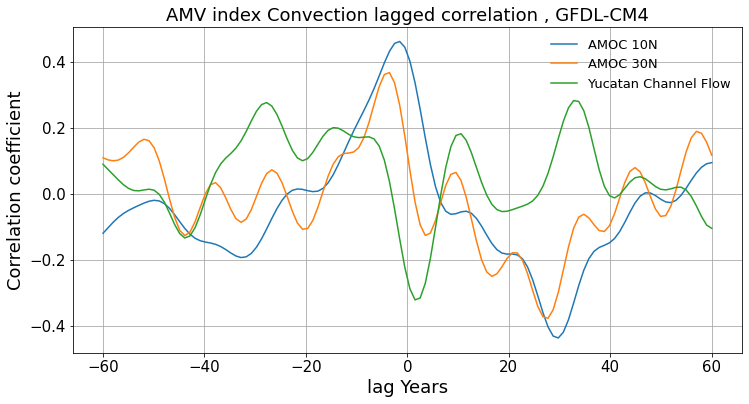

In [98]:
lag_time = 60

fig = plt.figure(figsize = (12,6)) 

x = np.linspace(-lag_time, lag_time, 2*lag_time)
plt.plot(x, lag_cor_data(butterwort_filter(10, 4, AMV.values), AMOC_bwfilt['10'], lag_time), 'C0', label = 'AMOC 10N')
plt.plot(x, lag_cor_data(butterwort_filter(10, 4, AMV.values), AMOC_bwfilt['30'], lag_time), 'C1', label = 'AMOC 30N')
plt.plot(x, lag_cor_data(butterwort_filter(10, 4, AMV.values), butterwort_filter(10, 4, flow_yct_ave.isel(lev=0).values), lag_time), 'C2', label = 'Yucatan Channel Flow')

plt.xlabel('lag Years', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13,frameon=False)
plt.grid(True, which="both", ls="-", color='0.65')
plt.title('AMV index Convection lagged correlation , {}'.format(model_name), fontsize=18)

In [68]:
client.close()
cluster.close()